# Rendering neurons with MeshParty

This notebook provides an entry point for creating renderings with MeshParty.

MeshParty is a library with convenience functions for loading and handling meshes and skeletons and also provides strong rendering capabilities (e.g. it was used for all renderings in figures 4-7 of the flywire connectome manuscript). It can be installed via
```
pip install meshparty
```
MeshParty uses cloudvolume for cloud access. It uses a meta object for managing meshes locally. It has a cache (in memory) and can also cache meshes on disk. 

This notebook builds on other notebooks introducing [the CAVEclient](https://github.com/seung-lab/FlyConnectome/blob/main/CAVE%20tutorial.ipynb) and [mesh access with cloudvolume](https://github.com/seung-lab/FlyConnectome/blob/main/Segmentation%20and%20Mesh%20Access.ipynb). 

We have an extensive documentation on meshparty's rendering capabilties here: https://meshparty.readthedocs.io/en/latest/guide/visualization.html

In [1]:
!pip install cloud-volume
!pip install meshparty
!pip install numpy

In [2]:
from meshparty import trimesh_vtk, trimesh_io
import cloudvolume

## Camera setup

The camera object defines all properties of the render besides the objects being rendered. Defining a camera object allows for reproducible renders and for multiple renders using the same view of a dataset. 

The camera object defines the location, perspective, and focal point of the camera (everything in nm). Importantly it also defines wheter a render uses orthogonal projection (`SetParallelProjection(1)`). <strong>It is highly recommended to use orthogonal projections because they allow for conistent scale bars to be added to the render. </strong> The easiest way to derive a scale bar is as follows: The height of the exported image equals two times the scale (`SetParallelScale(<scale>`). The camera below produces images that have a height of 1 mm in real world coordinates.

This camera is provided as a starting point. It was used for many renders in the flywire connectome manuscript.

In [3]:
front_camera = trimesh_vtk.oriented_camera(
    [0, 0, 0], # focus point
    backoff=1000, # put camera 1000 units back from focus
    backoff_vector=[0, 0, -1], # back off in negative z
    up_vector = [0, -1, 0] # make up negative y
)

front_camera.SetPosition((467131.73850273195, 53047.468364217784, -835168.9970166779))
front_camera.SetFocalPoint((515236.438405494, 266403.96453826834, 140620.3979797892))
front_camera.SetViewUp((0, -1, 0))
front_camera.SetParallelProjection(1)
front_camera.SetParallelScale(500000.0)

## Loading meshes

In [4]:
def mp_mesh_from_cv(cv, mesh_id):
    cv_mesh = cv.mesh.get(mesh_id)
    try:
        cv_mesh = cv_mesh[mesh_id]
    except:
        cv_mesh = cv_mesh
    return trimesh_io.Mesh(cv_mesh.vertices, cv_mesh.faces, cv_mesh.normals)

In [5]:
# The cloud path for the 630 release version (1st public release)
# seg_path = "precomputed://gs://flywire_v141_m630"

# The cloud path for the 783 release version (2nd public release)
seg_path = "precomputed://gs://flywire_v141_m783"

cv_seg = cloudvolume.CloudVolume(seg_path, use_https=True)

In [6]:
root_ids = [720575940631693610, 720575940605214636]
neuron_meshes = {root_id: mp_mesh_from_cv(cv_seg, root_id) for root_id in root_ids}

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.20s/it]


## Optional: Load neuropil mesh

In [7]:
np_path = "precomputed://gs://flywire_neuropil_meshes/whole_neuropil/brain_mesh_v3"

cv_np = cloudvolume.CloudVolume(np_path, use_https=True)
neuropil_mesh = mp_mesh_from_cv(cv_np, 1)

Decoding Mesh Buffer: 100%|██████████████████████| 1/1 [00:00<00:00, 847.33it/s]


## Creating mesh actors

Mesh actors are a combination of a mesh with parameters such as color and opacity and define how a mesh should be rendered.

In [8]:
colors = [[.8, .1, .2], [.1, .2, .8]]

neuron_mesh_actors = []
for root_id, color in zip(root_ids, colors):
    neuron_mesh_actors.append(trimesh_vtk.mesh_actor(neuron_meshes[root_id], color=color, opacity=1))

neuropil_mesh_actors = [trimesh_vtk.mesh_actor(neuropil_mesh, face_colors=(1., 1., 1.), opacity=.1)]

## Rendering

`trimesh_vtk.render_actors` takes a list of mesh actors and a camera to produce a rendering. It has two modes that can be toggled with `do_save`. `do_save=True` saves the image to disk, `do_save=False` opens a VTK window that allows for interactive viewing of the scene. Changes to the camera that are being made in the interactive viewing mode are written back to the camera object. This can be useful to create new camera settings but be sure to reset the camera. The cell stays active during this time and the window has to be closed before other cells can be executed.

The `scale` parameter sets the size of the image in pixels and therefore the resolution of the image. `scale=4` is sufficient for most cases and `scale=10` already produces very large images. If more details is required that might be a good point to change the camera and zoom in. 

Unfortunately, not every local setup works well with VTK. It is not uncommon that the VTK will not close but still exits. This is inconvenient but has no functional ramifications.

In [9]:
render_dir = "path to where to store the images>"

In [10]:
trimesh_vtk.render_actors(neuron_mesh_actors, 
                          camera=front_camera, 
                          do_save=True, scale=4, 
                          filename=f"{render_dir}/neuron_render.png")   

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x7ff4a763b400) at 0x14b91e020>

In [11]:
trimesh_vtk.render_actors(neuron_mesh_actors + neuropil_mesh_actors, 
                          camera=front_camera, 
                          do_save=True, scale=4, 
                          filename=f"{render_dir}/neuron_render_with_neuropil.png")   

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLRenderer(0x7ff4ad813000) at 0x14b91e9e0>

The resulting image:

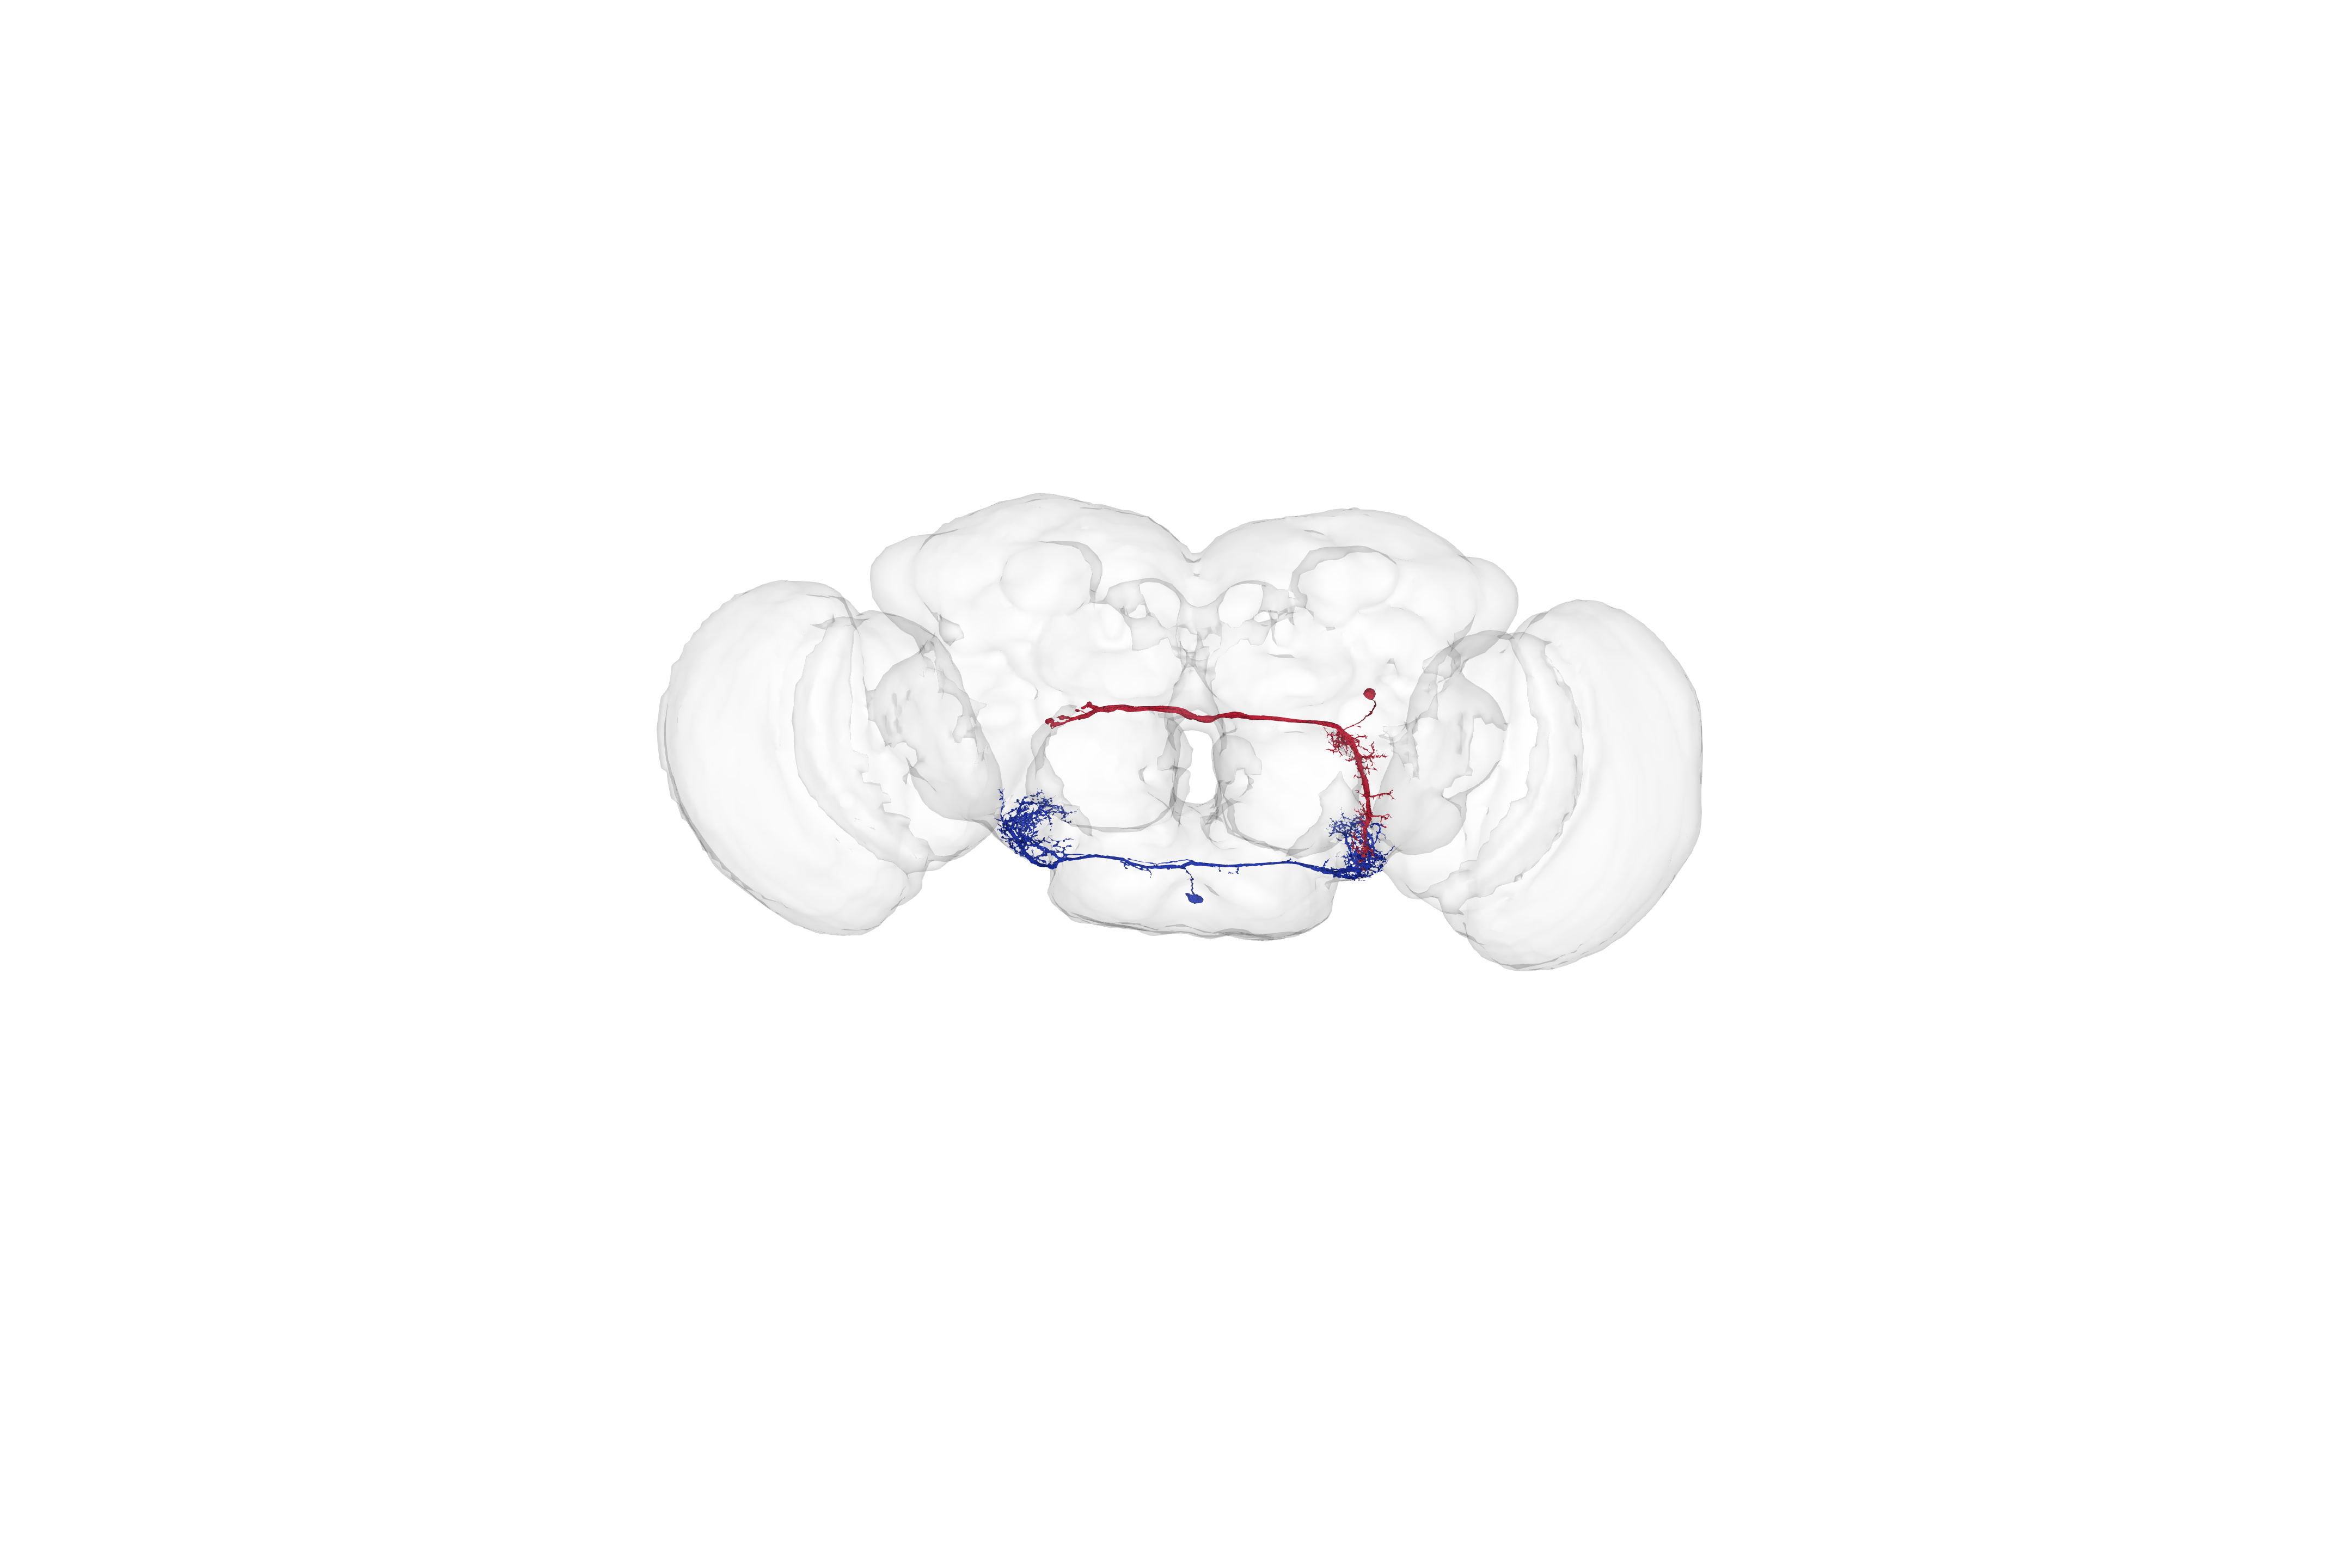